<a href="https://colab.research.google.com/github/MohammedAli-11/COVID-19-Detection-Using-Deep-Learning/blob/main/COVID_19_Classifier_using_dim_reduction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import os
import pathlib
import random
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import and explore dataset

In [3]:
L = 0
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/465 Project/Final Dataset"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")
    L = L + len(filenames)

There are 2 directories and 0 images in '/content/drive/MyDrive/465 Project/Final Dataset'
There are 2 directories and 0 images in '/content/drive/MyDrive/465 Project/Final Dataset/Val'
There are 0 directories and 30 images in '/content/drive/MyDrive/465 Project/Final Dataset/Val/Covid'
There are 0 directories and 30 images in '/content/drive/MyDrive/465 Project/Final Dataset/Val/Normal'
There are 2 directories and 0 images in '/content/drive/MyDrive/465 Project/Final Dataset/train'
There are 0 directories and 3875 images in '/content/drive/MyDrive/465 Project/Final Dataset/train/COVID'
There are 0 directories and 1341 images in '/content/drive/MyDrive/465 Project/Final Dataset/train/NORMAL'


In [5]:
data_dir = pathlib.Path("/content/drive/MyDrive/465 Project/Final Dataset/train") 
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['COVID' 'NORMAL']


In [6]:
def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img, cmap="gray")
  plt.title(target_class)
  plt.axis("off")
  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (1216, 1736)


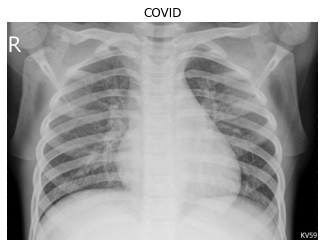

In [10]:
img = view_random_image(target_dir="/content/drive/MyDrive/465 Project/Final Dataset/train/", target_class="COVID")

Image shape: (1410, 1646)


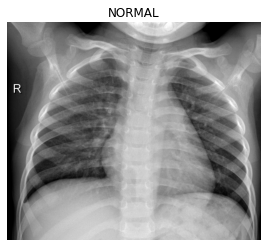

In [12]:
img = view_random_image(target_dir="/content/drive/MyDrive/465 Project/Final Dataset/train/", target_class="NORMAL")

# Preprocessing the images into an average vector

Required steps:
 1. Turn RGB images to grayscale
 2. Normalize the values between 0 and 1
 3. Resize the images to a regular size
 4. Project the images into a vector

## Preprocessing a single image

Image example shape: (760, 1152)


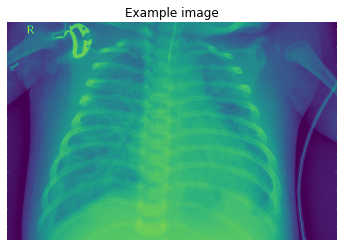

In [13]:
EXAMPLE_IMG_PATH = "/content/drive/MyDrive/465 Project/Final Dataset/train/COVID/person1000_bacteria_2931.jpeg"
img1 = mpimg.imread(EXAMPLE_IMG_PATH)
print(f"Image example shape: {img1.shape}")
plt.imshow(img1)
plt.title("Example image")
plt.axis("off")
plt.show()

### 1. Turn to grayscale

In [14]:
def rgb2gray(rgb_img):
    if rgb_img.ndim == 3:
        R, G, B = rgb_img[:, :, 0], rgb_img[:, :, 1], rgb_img[:, :, 2]
        output_img = 0.2989 * R + 0.5870 * G + 0.1140 * B
    else:
       output_img = rgb_img
    if output_img.max() < 1.1:
        output_img = output_img * 255
    return output_img

In [15]:
print(f"Shape before: {img1.shape}")
img2 = rgb2gray(img1)
print(f"Shape after: {img2.shape}")

Shape before: (760, 1152)
Shape after: (760, 1152)


### 2. Normalize values

In [16]:
def normalize_image(image):
    return image / 255

In [17]:
img3 = normalize_image(img2)
print(f"Max value before: {img2.max()}")
print(f"Max value after: {img3.max()}")

Max value before: 255
Max value after: 1.0


### 3. Resize

In [18]:
def resize_image(image, rows=224, cols=224):
    return cv2.resize(image, dsize=(rows, cols), interpolation=cv2.INTER_CUBIC)

In [19]:
img4 = resize_image(img3)
print(f"Shape before: {img3.shape}")
print(f"Shape after: {img4.shape}")

Shape before: (760, 1152)
Shape after: (224, 224)


### 4. Project image into a vector with the averages

In [20]:
def project_image(image, axis):
    return np.expand_dims(image.mean(axis=axis), axis=1)

In [21]:
mean_vector = project_image(img4, axis=1)
print(f"shape of the projected vector: {mean_vector.shape}")

shape of the projected vector: (224, 1)


### Result

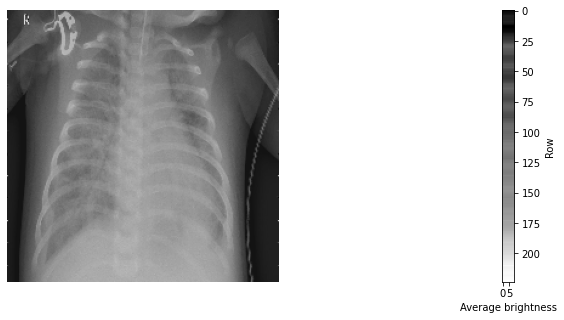

In [22]:
figure = plt.figure(figsize=[12,5])
plt.subplot(1, 2, 1)
plt.imshow(img4, cmap="gray")
plt.axis("off")
ax = plt.subplot(1, 2, 2)
mean_vector_img = np.tile(mean_vector, (1, 10))
plt.imshow(mean_vector_img, cmap='gray')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.ylabel("Row")
plt.xlabel("Average brightness")
plt.show()

## batch the whole dataset

In [23]:
def preprocesss_img(input_img):
    output_img = rgb2gray(input_img)
    output_img = normalize_image(output_img)
    output_img = resize_image(output_img)
    output_img = project_image(output_img, axis=1) # projecting the rows
    return output_img

In [24]:
# matrix containing L vectors of shape (224, 1)
mean_vector_matrix = np.zeros(shape=(L, 224, 1))
# Target vector containing the classes for L images
target_vector = np.zeros(shape=(L, 1))

In [27]:
# fill the matrix with normal class images. Class "1"
n = 0
for root, dirnames, filenames in os.walk("/content/drive/MyDrive/465 Project/Final Dataset/train/NORMAL"):
    n_total = len(filenames)
    for filename in filenames:
        file_path = os.path.join(root, filename)
        img = mpimg.imread(file_path)
        img = preprocesss_img(img)
        mean_vector_matrix[n] = img
        target_vector[n] = 1
        if n % 40 == 0:
            print(f"File {n}/{n_total}\t {filename}")
        n = n + 1  

File 0/1341	 IM-0618-0001-0002.jpeg
File 40/1341	 IM-0408-0001.jpeg
File 80/1341	 IM-0669-0001.jpeg
File 120/1341	 IM-0387-0001.jpeg
File 160/1341	 IM-0643-0001.jpeg
File 200/1341	 NORMAL2-IM-0643-0001.jpeg
File 240/1341	 NORMAL2-IM-0655-0001.jpeg
File 280/1341	 NORMAL2-IM-0386-0001.jpeg
File 320/1341	 NORMAL2-IM-0781-0001.jpeg
File 360/1341	 NORMAL2-IM-0872-0001.jpeg
File 400/1341	 NORMAL2-IM-0550-0001.jpeg
File 440/1341	 NORMAL2-IM-0648-0001.jpeg
File 480/1341	 NORMAL2-IM-0834-0001.jpeg
File 520/1341	 NORMAL2-IM-0572-0001.jpeg
File 560/1341	 NORMAL2-IM-0435-0001.jpeg
File 600/1341	 NORMAL2-IM-0862-0001.jpeg
File 640/1341	 NORMAL2-IM-1266-0001-0001.jpeg
File 680/1341	 NORMAL2-IM-1219-0001.jpeg
File 720/1341	 NORMAL2-IM-1225-0001.jpeg
File 760/1341	 NORMAL2-IM-1016-0001.jpeg
File 800/1341	 NORMAL2-IM-1365-0001.jpeg
File 840/1341	 NORMAL2-IM-1236-0001.jpeg
File 880/1341	 NORMAL2-IM-1315-0001.jpeg
File 920/1341	 NORMAL2-IM-1126-0001.jpeg
File 960/1341	 NORMAL2-IM-0948-0001.jpeg
File 1000

In [28]:
# fill the matrix with covid class images. Class "0"
for root, dirnames, filenames in os.walk("/content/drive/MyDrive/465 Project/Final Dataset/train/COVID"):
    n_total = len(filenames)
    for filename in filenames:
        file_path = os.path.join(root, filename)
        img = mpimg.imread(file_path)
        img = preprocesss_img(img)
        mean_vector_matrix[n] = img
        target_vector[n] = 0
        if n % 40 == 0:
            #print(f"File {n-196}/{n_total}\t {filename}")
            print(f"File {n}/{n_total}\t {filename}")
        n = n + 1  

File 1360/3875	 person544_virus_1074.jpeg
File 1400/3875	 person608_bacteria_2473.jpeg
File 1440/3875	 person605_bacteria_2465.jpeg
File 1480/3875	 person368_bacteria_1667.jpeg
File 1520/3875	 person388_virus_775.jpeg
File 1560/3875	 person413_bacteria_1832.jpeg
File 1600/3875	 person61_bacteria_292.jpeg
File 1640/3875	 person58_bacteria_273.jpeg
File 1680/3875	 person74_bacteria_361.jpeg
File 1720/3875	 person805_bacteria_2712.jpeg
File 1760/3875	 person744_virus_1367.jpeg
File 1800/3875	 person574_bacteria_2372.jpeg
File 1840/3875	 person492_bacteria_2085.jpeg
File 1880/3875	 person297_bacteria_1400.jpeg
File 1920/3875	 person696_bacteria_2594.jpeg
File 1960/3875	 person45_bacteria_222.jpeg
File 2000/3875	 person457_bacteria_1949.jpeg
File 2040/3875	 person703_virus_1300.jpeg
File 2080/3875	 person628_virus_1206.jpeg
File 2120/3875	 person475_virus_972.jpeg
File 2160/3875	 person96_virus_178.jpeg
File 2200/3875	 person936_bacteria_2861.jpeg
File 2240/3875	 person924_bacteria_2849.jpe

# Model creation and fit

In [30]:
# Set a seed for reproducible results
SEED = 0
x_train, x_test, y_train, y_test = train_test_split(mean_vector_matrix, target_vector, test_size=0.2, random_state=SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [31]:
#Tiny VGG architecture adapted to 1 dimension data
model = tf.keras.models.Sequential([
                tf.keras.layers.Conv1D(filters=10, kernel_size=3, activation="relu", input_shape=(224, 1)),
                tf.keras.layers.Conv1D(filters=10, kernel_size=3, activation="relu"),
                tf.keras.layers.MaxPool1D(pool_size=2),
                tf.keras.layers.Conv1D(filters=10, kernel_size=3, activation="relu"),
                tf.keras.layers.Conv1D(filters=10, kernel_size=3, activation="relu"),
                tf.keras.layers.MaxPool1D(pool_size=2),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(1, activation="sigmoid")
])

In [32]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 222, 10)           40        
                                                                 
 conv1d_1 (Conv1D)           (None, 220, 10)           310       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 110, 10)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 108, 10)           310       
                                                                 
 conv1d_3 (Conv1D)           (None, 106, 10)           310       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 53, 10)           0         
 1D)                                                    

In [44]:
history = model.fit(x=x_train, y=y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(x_test, y_test),
                    verbose=False)

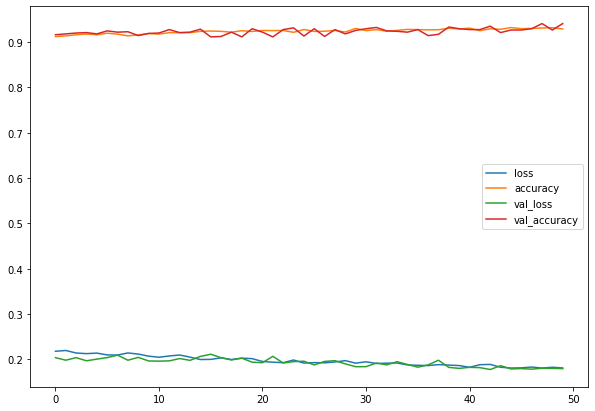

In [45]:
pd.DataFrame(history.history).plot(figsize=(10, 7));

In [46]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=False)
print(f"loss: {test_loss:0.3}\t accuracy: {test_accuracy:0.2%}")

loss: 0.18	 accuracy: 94.03%
